In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
psfMag_col = [c for c in train.columns if c.find('psfMag')!=-1]
fiberMag_col = [c for c in train.columns if c.find('fiberMag')!=-1]
petroMag_col = [c for c in train.columns if c.find('petroMag')!=-1]
modelMag_col = [c for c in train.columns if c.find('modelMag')!=-1]

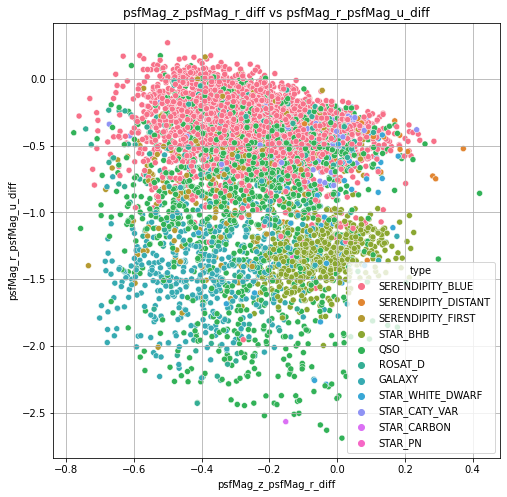

In [4]:
train_eda = train.copy(deep=True)

for c in psfMag_col:
    upper_bound = np.percentile(train_eda[c],75)
    lower_bound = np.percentile(train_eda[c],25)
    mask = (train_eda[c] >= lower_bound) & (train_eda[c] <= upper_bound)
    train_eda = train_eda[mask]

diff_feature = []
for c1, c2 in itertools.combinations(psfMag_col[::-1],2):
    new_c = f'{c1}_{c2}_diff'
    train_eda[new_c] = train_eda[c1]-train_eda[c2]
    diff_feature.append(new_c)

"""
for i, (c1,c2) in enumerate(itertools.combinations(diff_feature,2)):
    plt.figure(figsize=(8,8))
    sns.scatterplot(c1,c2, data=train_eda, hue='type')
    plt.title(f'{c1} vs {c2}')
    plt.grid()
    plt.show()
    draw_count+=1 
"""

# 2 Mb 용량 제한 때문에 대표 하나만 그림
c1 = 'psfMag_z_psfMag_r_diff'
c2 = 'psfMag_r_psfMag_u_diff'
plt.figure(figsize=(8,8))
sns.scatterplot(c1,c2, data=train_eda, hue='type')
plt.title(f'{c1} vs {c2}')
plt.grid()
plt.show()

In [5]:
train_eda_ = train_eda.drop(columns=['type'], axis=1)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_eda_)
X_scaled = scaler.transform(train_eda_)

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 6)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print(X_scaled.shape)
print(X_pca.shape)

(6249, 32)
(6249, 6)


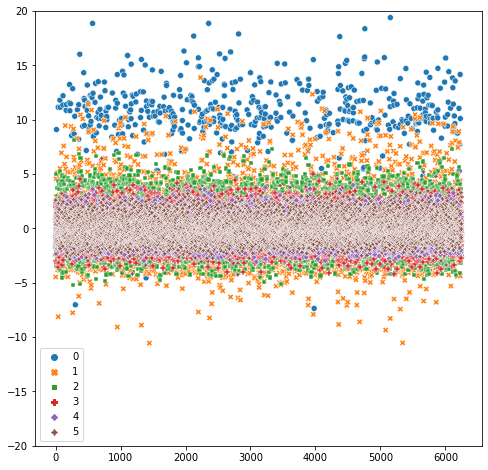

In [8]:
plt.figure(figsize=(8,8))
sns.scatterplot(data = X_pca)
plt.ylim([-20, 20])
plt.show()

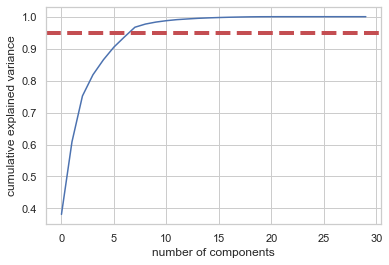

None

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
pca_test = PCA(n_components=30)
pca_test.fit(X_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(linewidth=4, color='r', linestyle = '--', y=0.95, xmin=0, xmax=30)
display(plt.show())

In [10]:
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.381508,0.381508
1,0.608353,0.226845
2,0.752055,0.143702
3,0.818291,0.066236
4,0.865338,0.047046
5,0.905047,0.039709
6,0.936684,0.031637
7,0.967071,0.030388
8,0.976958,0.009887
9,0.983183,0.006225


In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state = 42)

type_tsne = tsne.fit_transform(X_scaled)

In [12]:
colors = ['#93DAFF', '#3DFF92', '#FFB6C1', '#FF82FF', '#FAEB78',
         '#FF8200', '#8B4513', '#FF0000', '#828282', '#41CDCD',
         '#000069', '#329632', '#CD1039', '#8B6331', '#A83CA8',
         '#505050', '#FF0000', '#00AFFF', '#3C5A91']

In [13]:
color_dict = {}
for type_, color in zip(list(train['type'].unique()), colors):
    color_dict[type_] = color

In [14]:
color_dict

{'QSO': '#93DAFF',
 'STAR_RED_DWARF': '#3DFF92',
 'SERENDIPITY_BLUE': '#FFB6C1',
 'STAR_BHB': '#FF82FF',
 'STAR_CATY_VAR': '#FAEB78',
 'SERENDIPITY_DISTANT': '#FF8200',
 'GALAXY': '#8B4513',
 'SPECTROPHOTO_STD': '#FF0000',
 'REDDEN_STD': '#828282',
 'ROSAT_D': '#41CDCD',
 'STAR_WHITE_DWARF': '#000069',
 'SERENDIPITY_RED': '#329632',
 'STAR_CARBON': '#CD1039',
 'SERENDIPITY_FIRST': '#8B6331',
 'STAR_BROWN_DWARF': '#A83CA8',
 'STAR_SUB_DWARF': '#505050',
 'SKY': '#FF0000',
 'SERENDIPITY_MANUAL': '#00AFFF',
 'STAR_PN': '#3C5A91'}

In [15]:
# plt.figure(figsize = (10,10))
# plt.xlim(X_scaled[:,0].min(), X_scaled[:,0].max() + 1)
# plt.ylim(X_scaled[:,1].min(), X_scaled[:,1].max() + 1)
# for i in range(len(X_scaled)):
#     plt.text(type_tsne[i,0], type_tsne[i,1], str(train['type'][i]),
#              color = color_dict[train['type'][i]],
#              fontdict = {'weight' : 'bold', 'size' : 9})
# plt.xlabel('tsne특성0')
# plt.ylabel('tsne특성1')